In [31]:
import queue
import copy
import random
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Node:
    def __init__(self,value,level=None):
        self.parent = None
        self.right = None
        self.left = None
        self.val = value
        self.level = level
    #__lt__() odpowiada za porównywanie dwóch nodeów
    #potrzebne w kolejce priorytetowej
    def __lt__(self, other):
        return self.val < other.val
    def next(self):
        if self.right:
            succ =self.right
            while succ.left:
                succ = succ.left
            return succ
        if self.parent.left == self:
            return self.parent
        return None
    def precedes(self,other):
        head1 = self
        head2 = other
        if head1 is head2:
            return False
        while head1 and head2:
            if head1.parent == head2.parent:
                if head1 == head1.parent.left:
                    return True
                return False
            head1=head1.parent
            head2=head2.parent

In [3]:
def huffman_code(text):
    letters = dict()
    for letter in text:
        if letter in letters:
            letters[letter]+=1
        else:
            letters[letter]=1
    Q = queue.PriorityQueue()
    for letter in letters.keys():
        Q.put((letters[letter],Node(letter)))
    while not Q.empty():
        node1 = Q.get()
        if Q.empty():
            tree = node1[1]
            break
        node2 = Q.get()
        new = Node(node1[1].val+node2[1].val)
        new.right = node1[1]
        new.left = node2[1]
        Q.put((node1[0]+node2[0],new))
    nodes = queue.SimpleQueue()
    nodes.put((tree,''))
    while not nodes.empty():
        node = nodes.get()
        if len(node[0].val) ==1:
            letters[node[0].val] = node[1]
        if node[0].left!=None:
            nodes.put((node[0].left,node[1]+'0'))
        if node[0].right!=None:
            nodes.put((node[0].right,node[1]+'1'))
    coded = ''.join([letters[t] for t in text])
    return coded,letters
            

In [4]:
code,a = huffman_code("Litwo Ojczyzno Moja! Ty jesteś jak zdrowie!")

In [5]:
a

{'L': '001011',
 'i': '00001',
 't': '1010',
 'w': '1001',
 'o': '110',
 ' ': '011',
 'O': '001001',
 'j': '111',
 'c': '000101',
 'z': '0100',
 'y': '1000',
 'n': '000000',
 'M': '001010',
 'a': '00011',
 '!': '00110',
 'T': '001000',
 'e': '0101',
 's': '10110',
 'ś': '00111',
 'k': '000001',
 'd': '000100',
 'r': '10111'}

In [6]:
code

'001011000011010100111001100100111100010101001000010000000011001100101011011100011001100110010001000011111010110110101001010011101111100011000001011010000010010111110100100001010100110'

In [7]:
def add_levels(node,a,levels,stop):
    Q = queue.SimpleQueue()
    levels[node.level].remove(node)
    node.level+=a
    levels[node.level].add(node)
    Q.put(node)
    while not Q.empty():
        x = Q.get()
        l,r = x.left,x.right
        if l and l is not stop:
            levels[l.level].remove(l)
            l.level+=a
            levels[l.level].add(l)
            Q.put(l)
        if r and r is not stop:
            levels[r.level].remove(r)
            r.level+=a
            levels[r.level].add(r)
            Q.put(r)
        

In [8]:
def change_nodes(nodeA,nodeB,levels):
    if nodeA.parent == nodeB.parent:
        parent = nodeA.parent
        parent.right,parent.left = parent.left,parent.right
        return
    parentA = nodeA.parent
    if parentA.left == nodeA:
        parentA.left = nodeB
    else:
        parentA.right = nodeB
    nodeA.parent = nodeB.parent
    if nodeB.parent.left == nodeB:
        nodeB.parent.left = nodeA
    else:
        nodeB.parent.right = nodeA
    nodeB.parent = parentA
    diff = nodeB.level - nodeA.level
    if diff != 0:
        add_levels(nodeA,diff,levels,nodeB)
        add_levels(nodeB,-diff,levels,None)

In [9]:
def add_node(tree,node,levels):
    parent = Node(0,tree.level)
    levels[tree.level].remove(tree)
    node.parent = parent
    parent.right = node
    tree_parent = tree.parent
    tree.parent = parent
    parent.left = tree
    parent.parent = tree_parent
    if tree_parent != None:
        if tree_parent.left == tree:
            tree_parent.left = parent
        else:
            tree_parent.right = parent
    tree.level += 1
    node.level = tree.level
    if parent.level in levels:
        levels[parent.level].add(parent)
    else:
        levels[parent.level] = {parent}
    if tree.level in levels:
        levels[tree.level].add(tree)
    else:
        levels[tree.level] = {tree}
    levels[node.level].add(node)

In [10]:
def check_conflicts(node,tree,levels,repeats,nodes):
    head = node
    while head:
        if head.val in repeats:
            upper = list(repeats[head.val])
            for u in upper:
                uNode = nodes[u]
                if uNode.level < head.level and head.parent != uNode:
                    change_nodes(uNode,head,levels)
        top = head
        while  top.parent:
            top = top.parent
        if head:
            block = list(levels[head.level])
            for b in block:
                if head.precedes(b) and b.val == head.val:
                    change_nodes(b,head,levels)
        head.val+=1
        head = head.parent
            

In [11]:
def dynamic_huffman_code(text):
    tree = Node(0,0)
    letters= {'':0} #letter -> how often does it repeat
    repeats = {0:['']}
    letters_list = [''] #index -> letter
    nodes = {'':tree} #letter -> it's node
    levels = {0:{tree}}
    for letter in text:
        letter = str(letter)
        if letter in letters:
            check_conflicts(nodes[letter],tree,levels,repeats,nodes)
            repeats[letters[letter]].remove(letter)
            letters[letter]+=1
            if letters[letter] in repeats:
                repeats[letters[letter]].add(letter)
            else:
                repeats[letters[letter]]={letter}
        else:
            letters[letter] = 1
            letters_list.append(letter)
            node = Node(0,tree.level+1)
            add_node(tree,node,levels)
            nodes[letter] = node
            check_conflicts(node,tree,levels,repeats,nodes)
            if not 1 in repeats:
                repeats[1]=[]
            repeats[1].append(letter)
        head = tree
        while  head.parent:
            head = head.parent
    return tree,nodes

In [13]:
text = "Litwo Ojczyzno Moja!\nTy jesteś jak zdrowie!"
tree,tree_dict = dynamic_huffman_code(text)

In [79]:
def encode_dynamic(tree,node_dict,text):
    head = tree
    reverse_dict =dict()
    for k in node_dict.keys():
        reverse_dict[node_dict[k]]=k
    while head.parent:
        head = head.parent
    tree_parent = tree.parent
    if not tree_parent.parent:
        head = tree_parent.right
    else:
        super_parent = tree_parent.parent
        end = tree_parent.right
        end.parent = super_parent
        super_parent.left = end
    nodes = queue.SimpleQueue()
    nodes.put((head,''))
    letters = dict()
    while not nodes.empty():
        node = nodes.get()
        if node[0] in reverse_dict:
            letters[reverse_dict[node[0]]] = str(node[1])
        if node[0].left:
            nodes.put((node[0].left,node[1]+'0'))
        if node[0].right:
            nodes.put((node[0].right,node[1]+'1'))
    coded = ''.join([letters[t] for t in text])
    return coded, letters

In [15]:
code,letters = encode_dynamic(tree,tree_dict,text)

In [16]:
code

'111110110100110110111110101000000010100011000111110001010111010110000111000100011000110101011011110100110010100101101001000011010010001111111101110011110111110011101101111010100110001'

In [17]:
def write(code,filename):
    n_bytes = len(code)//8#pełne bajty
    rest = len(code)%8
    int_array = []
    for i in range(n_bytes):
        int_array.append(int(code[i*8:i*8+8],2))
    last_byte = rest#w ostatnim bajcie zapisuję jak dużo należy odczytać z przedostatniego bajtu
    if rest !=0:
        rest_byte = int(code[len(code)-rest:],2)
        int_array.append(rest_byte)
    int_array.append(last_byte)
    with open (filename,'wb') as file:
        file.write(bytes(int_array))

In [18]:
def to_binary(integer):
    bin_val=bin(integer)[2:]
    zeros = '0'*(8-len(bin_val))
    return zeros + bin_val

In [19]:
def read(filename):
    with open (filename,'rb') as file:
        byte_content = file.read()
    n= len(byte_content)-1
    rest_len = byte_content[-1]
    rest =""
    if rest_len != 0:
        n-=1
        rest  = to_binary(byte_content[-2])[8-rest_len:]
    bin_arr = []
    int_arr = []
    for i in range(n):
        bin_arr.append(to_binary(byte_content[i]))
    bin_arr.append(rest)
    return ''.join(bin_arr)

In [20]:
write(code, "bytefile.txt")

In [21]:
read("bytefile.txt")

'111110110100110110111110101000000010100011000111110001010111010110000111000100011000110101011011110100110010100101101001000011010010001111111101110011110111110011101101111010100110001'

In [22]:
def decode(code, letters):
    i = 0
    n = len(code)
    codes =dict()
    for c in letters.keys():
        codes[letters[c]]=c
    current =""
    decoded =""
    while i < n:
        current += code[i]
        if current in codes:
            decoded += codes[current]
            current = ""
        i += 1
    return decoded

In [23]:
decode(code,letters)

'Litwo Ojczyzno Moja! Ty jesteś jak zdrowie!'

In [24]:
files = ["1kB.txt","10kB.txt","100kB.txt","1MB.txt"]
sizes = [10**3,10**4,10**5,10**6]

In [25]:
def randomize_files():
    for i in range(4):
        filepath = "Random/"+files[i]
        size = sizes[i]*2//3
        with open(filepath,'w',encoding='utf-8') as file:
            for i in range(size):
                letter = chr(random.randint(0,255))
                file.write(letter)
        

In [26]:
randomize_files()

In [27]:
folders = ["Gutemberg","Linux_kernel","Random"]

In [80]:
#Testowanie algorytmów, to może potrwać dłuższą chwilę
sizes = [[],[],[]]

D_compression = [[],[],[]]
S_compression = [[],[],[]]

D_compression_times = [[],[],[]]
S_compression_times = [[],[],[]]

D_decompression_times = [[],[],[]]
S_decompression_times = [[],[],[]]

for i,folder in enumerate(folders):
    for file in files:
        filepath = folder +"/"+file
        print(filepath)
        input_size = os.stat(filepath).st_size
        sizes[i].append(input_size)

        output_S = folder +"/"+file+"compressed_static"
        output_D = folder +"/"+file+"compressed_dynamic"

        with open(filepath,'r',encoding='utf-8') as input_file:
            content = input_file.read()

        start = datetime.datetime.now()

        dynamicT, dynamicN = dynamic_huffman_code(content)
        dynamic, dynamic_dict = encode_dynamic(dynamicT, dynamicN,content)

        D_end = datetime.datetime.now()

        static, static_dict = huffman_code(content)

        S_end = datetime.datetime.now()

        D_compression_times[i].append((D_end-start).microseconds)
        S_compression_times[i].append((S_end-D_end).microseconds)

        write(static,output_S)
        write(dynamic,output_D)

        S_size = os.stat(output_S).st_size
        D_size = os.stat(output_D).st_size

        D_compression[i].append((input_size-D_size)/input_size)
        S_compression[i].append((input_size-D_size)/input_size)
        
        start = datetime.datetime.now()
        
        decode(dynamic,dynamic_dict)
        
        D_end = datetime.datetime.now()
        
        decode(static,static_dict)
        
        S_end = datetime.datetime.now()
        
        D_decompression_times[i].append((D_end-start).microseconds)
        S_decompression_times[i].append((S_end-D_end).microseconds)

Gutemberg/1kB.txt
Gutemberg/10kB.txt
Gutemberg/100kB.txt
Gutemberg/1MB.txt
Linux_kernel/1kB.txt
Linux_kernel/10kB.txt
Linux_kernel/100kB.txt
Linux_kernel/1MB.txt
Random/1kB.txt
Random/10kB.txt
Random/100kB.txt
Random/1MB.txt


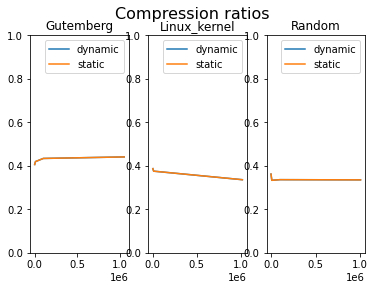

In [81]:
fig,axes = plt.subplots(1,3)
fig.suptitle('Compression ratios', fontsize=16)
for i in range(3):
    lineD, = axes[i].plot(sizes[i],D_compression[i], label = 'dynamic')
    lineS, = axes[i].plot(sizes[i],S_compression[i], label = 'static')
    axes[i].set_title(folders[i])
    axes[i].set_ylim(0,1)
    axes[i].legend()

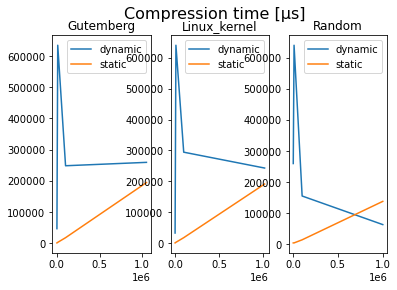

In [82]:
fig,axes = plt.subplots(1,3)
fig.suptitle('Compression time [μs]', fontsize=16)
for i in range(3):
    lineD, = axes[i].plot(sizes[i],D_compression_times[i], label = 'dynamic')
    lineS, = axes[i].plot(sizes[i],S_compression_times[i], label = 'static')
    axes[i].set_title(folders[i])
    axes[i].legend()

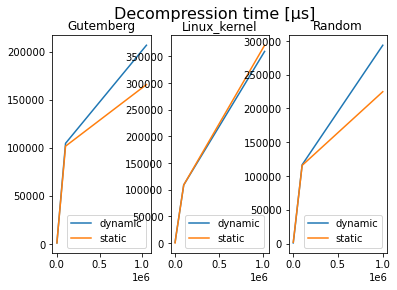

In [83]:
fig,axes = plt.subplots(1,3)
fig.suptitle('Decompression time [μs]', fontsize=16)
for i in range(3):
    lineD, = axes[i].plot(sizes[i],D_decompression_times[i], label = 'dynamic')
    lineS, = axes[i].plot(sizes[i],S_decompression_times[i], label = 'static')
    axes[i].set_title(folders[i])
    axes[i].legend()

# Opis
Algorytm dynamiczny w mojej implementacji w celu skutecznej i szybkiej zamiany i wyszukiwania węzłów na tym samym poziomie lub węzłów o takich samych wagach korzysta ze słowników przechowujących jako klucze odpowiednio numer poziomu/liczbę powtórzeń a jako wartości zbiory węzłów/listy liter. Co do rodzaju pliku na którym odbywa się zapisanie skompresowanych danych, to dopełniam ostatni bajt zerami z przodu (jeżeli jego długość jest niezerowa)  i dodaję jeszcze jeden bajt określający ile bajtów ma mieć odczytana część "resztowego" bajtu. Plik ten jest w formacie .txtcompressed_static,lub .txtcompressed_dynamic, ale dane do niego zapisywane nie są tekstem, a ciągiem bitów zamienionym na int, a potem na bajty przy pomocy funkcji bytes().

# Wnioski
W większości wypadków współczynniki kompresji obu algorytmów były bardzo podobne. Stalo się tak min. dlatego, że w algorytmie adaptacyjnym, pozbywałem się pustego węzła skracając drzewo. Niestety jeśli chodzi o czas działania, to algorytm dynamiczny okazał się znacznie wolniejszy od zwykłego (plik losowy o rozmiarze 1MB okazał się wyjątkiem). Między czasami dekompresji algorytmów różnice były niewielkie. Nieco wolniejszy okazał się algorytm dynamiczny (tu z kolei wyjątkiem są pliki z jądra linuxa).